In [ ]:
# should process a grid search for lstm?
do_grid_search = False

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession

session = SnorkelSession()

In [2]:
from ksnorkel import KSUtils

train_sent, dev_sent, test_sent = KSUtils.split_sentences(session)
print("Amount of sentences: {} train, {} dev and {} test".format(len(train_sent), len(dev_sent), len(test_sent)))

Amount of docs: 9645
Document splitted: 3215 train, 3215 dev and 3215 test
Amount of sentences: 27763 train, 27526 dev and 27823 test


In [3]:
from snorkel.models import Candidate, candidate_subclass
from snorkel.candidates import PretaggedCandidateExtractor

GeneDiseaseInteraction = candidate_subclass('GeneDiseaseInteraction', ['gene', 'disease'])
candidate_extractor = PretaggedCandidateExtractor(GeneDiseaseInteraction, ['Gene', 'Disease'])

for k, sents in enumerate([train_sent,dev_sent, test_sent]):
    candidate_extractor.apply(sents, split=k, clear=True)
    print("Number of candidates:", session.query(GeneDiseaseInteraction).filter(GeneDiseaseInteraction.split == k).count())

Clearing existing...


  0%|          | 67/27763 [00:00<00:44, 626.21it/s]

Running UDF...


100%|██████████| 27763/27763 [00:10<00:00, 2628.94it/s]


Number of candidates: 3051
Clearing existing...


  0%|          | 34/27526 [00:00<01:23, 329.83it/s]

Running UDF...


100%|██████████| 27526/27526 [00:10<00:00, 2558.60it/s]


Number of candidates: 3304
Clearing existing...


  0%|          | 107/27823 [00:00<00:26, 1065.80it/s]

Running UDF...


100%|██████████| 27823/27823 [00:10<00:00, 2708.37it/s]

Number of candidates: 3124


In [4]:
import gzip
import re

ctd_gene_disease_inter = set()
i = 0
with gzip.open('data/CTD_genes_diseases.tsv.gz','r') as f:
    for l in f:
        line = str(l).replace('b\'', '').replace('\\n\'', '').replace('\\r','')
        # skip comments
        if line.startswith('#'):
            continue
        #print(line)
        components = line.split('\\t')    
        
        # add MESH:
        if not components[3].startswith('MESH:'):
            components[3] = "MESH:" + components[1]
        
        #print(components)
        gene = components[1]
        disease = components[3]
        key = frozenset((gene, disease))
        #print(key)
        ctd_gene_disease_inter.add(key)
        i += 1


    
print('{} chemical-gene assocations read from ChG-CTD_chem_gene_ixns'.format(len(ctd_gene_disease_inter)))
#240349

25339259 chemical-gene assocations read from ChG-CTD_chem_gene_ixns


In [5]:
def cand_in_gene_disease_interactions(c):
    key = frozenset((c.gene_cid, c.disease_cid))
    if key in ctd_gene_disease_inter:
    #    print(key)
        return 1
    return -1

In [6]:
from ksnorkel import KSUtils

KSUtils.add_gold_labels_for_candidates(session, GeneDiseaseInteraction, cand_in_gene_disease_interactions)

Clearing existing gold labels...
Adding gold labels to training candidates...
Labeld 1738 positive and 1313 negative samples in train
Adding gold labels to develop candidates...
Labeld 2140 positive and 1164 negative samples in dev
Adding gold labels to test candidates...
Labeld 1908 positive and 1216 negative samples in test
Finished - commiting to database...
Commit complete!
Labeld 5786 positive and 3693 negative samples


In [7]:
import re

def LF_GD_in_CTD_chem_gene(c):
    if cand_in_gene_disease_interactions(c) == 1:
        return 1
    else:
        return -1


LFs_GD = [
    LF_GD_in_CTD_chem_gene
]

In [8]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs_GD)
%time L_train = labeler.apply(lfs=LFs_GD, parallelism=1)
L_train

L_train.lf_stats(session)

  3%|▎         | 79/3051 [00:00<00:03, 782.61it/s]

Clearing existing...
Running UDF...


100%|██████████| 3051/3051 [00:04<00:00, 760.18it/s]


CPU times: user 4.07 s, sys: 28 ms, total: 4.1 s
Wall time: 4.09 s


,j,Coverage,Overlaps,Conflicts
LF_GD_in_CTD_chem_gene,0,1.0,0.0,0.0


In [9]:
from snorkel.annotations import load_gold_labels

L_dev = labeler.apply_existing(split=1)
L_test = labeler.apply_existing(split=2)
L_gold_dev = load_gold_labels(session, annotator_name='gold',split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

  2%|▏         | 59/3304 [00:00<00:05, 588.59it/s]

Clearing existing...
Running UDF...


  1%|▏         | 46/3124 [00:00<00:06, 456.27it/s]

Clearing existing...
Running UDF...


100%|██████████| 3124/3124 [00:04<00:00, 692.72it/s]


In [10]:
from snorkel.learning import GenerativeModel
from snorkel.learning import RandomSearch
from snorkel.learning.structure import DependencySelector


MAX_DEPS = 5

ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
deps = set(list(deps)[0:min(len(deps), MAX_DEPS)])

print("Using {} dependencies".format(len(deps)))



# use random search to optimize the generative model
param_grid = {
    'step_size' : [1e-3, 1e-4, 1e-5, 1e-6],
    'decay'     : [0.9, 0.95],
    'epochs'    : [50,100],
    'reg_param' : [1e-3],
}

model_class_params = {'lf_propensity' : False }#, 'deps': deps}

searcher = RandomSearch(GenerativeModel, param_grid, L_train, n=5, model_class_params=model_class_params)
%time gen_model, run_stats = searcher.fit(L_dev, L_gold_dev) #, deps=deps)
run_stats

train_marginals = gen_model.marginals(L_train)

Using 0 dependencies
[1] Testing step_size = 1.00e-05, decay = 9.00e-01, epochs = 100, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 1.0
[GenerativeModel] Model saved as <GenerativeModel_0>.
[GenerativeModel] Model saved as <GenerativeModel_best>.
[2] Testing step_size = 1.00e-04, decay = 9.00e-01, epochs = 100, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 1.0
[3] Testing step_size = 1.00e-05, decay = 9.50e-01, epochs = 50, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 1.0
[4] Testing step_size = 1.00e-05, decay = 9.50e-01, epochs = 100, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 1.0
[5] Testing step_size = 1.00e-03, decay = 9.00e-01, epochs = 50, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 1.0
[GenerativeModel] Model <GenerativeModel_0> loaded.
CPU times: user 10.7 s, sys: 24 ms, total: 10.7 s
Wall time: 10.7 s


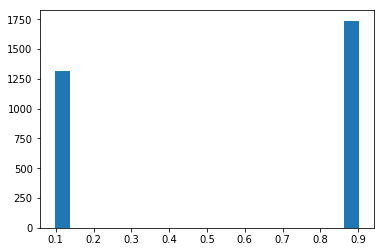

In [11]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [12]:
from snorkel.annotations import save_marginals

dev_marginals = gen_model.marginals(L_dev)
_, _, _, _ = gen_model.error_analysis(session, L_dev, L_gold_dev)

%time save_marginals(session, L_train, train_marginals)

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 1.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 2140 | FP: 0 | TN: 1164 | FN: 0

Saved 3051 marginals
CPU times: user 2.28 s, sys: 116 ms, total: 2.39 s
Wall time: 2.4 s


In [13]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 1.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 1908 | FP: 0 | TN: 1216 | FN: 0



In [14]:
print("Load all GeneDiseaseInteraction candidates from db...")
train_cands = session.query(GeneDiseaseInteraction).filter(GeneDiseaseInteraction.split == 0).order_by(GeneDiseaseInteraction.id).all()
dev_cands   = session.query(GeneDiseaseInteraction).filter(GeneDiseaseInteraction.split == 1).order_by(GeneDiseaseInteraction.id).all()
test_cands  = session.query(GeneDiseaseInteraction).filter(GeneDiseaseInteraction.split == 2).order_by(GeneDiseaseInteraction.id).all()


all_cands = []
all_cands.extend(train_cands)
all_cands.extend(dev_cands)
all_cands.extend(test_cands)


print("{} {} {}".format(len(train_cands), len(dev_cands), len(test_cands)))
print("Amount of all candidates: {}".format(len(all_cands)))

Load all GeneDiseaseInteraction candidates from db...
3051 3304 3124
Amount of all candidates: 9479


In [23]:
from snorkel.learning.pytorch import LSTM
from snorkel.annotations import load_gold_labels

#train_kwargs = {
#    'lr':            0.01,
#    'embedding_dim': 75,
#    'hidden_dim':    75,
#    'n_epochs':      100,
#    'dropout':       0.25,
#    'seed':          1701
#}

if not do_grid_search:
    # Best configuration
    train_kwargs = {
        'lr':            0.0010,
        'embedding_dim': 125,
        'hidden_dim':    100,
        'n_epochs':      100,
        'dropout':       0.50,
        'rebalance':     0.0,
        'seed':          1701
    }

    lstm = LSTM(n_threads=10)
    lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

    p, r, f1 = lstm.score(test_cands, L_gold_test)
    print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

SyntaxError: invalid syntax (<ipython-input-23-903cac04292d>, line 13)

In [16]:
#from snorkel.learning import RandomSearch
#from snorkel.learning.pytorch import LSTM

if do_grid_search:
    seed = 12345
    num_model_search = 25

    # search over this parameter grid
    param_grid = {}
    param_grid['batch_size'] = [64, 128]
    param_grid['lr']         = [1e-4, 1e-3, 1e-2]
    param_grid['rebalance']  = [0.0,0.25, 0.5]
    param_grid['embedding_dim'] = [75, 100, 125]
    param_grid['hidden_dim'] = [50, 100, 150]
    param_grid['dropout'] = [0, 0.25, 0.5]

    model_class_params = {
        'n_threads':1
    }


    model_hyperparams = {
        'n_epochs': 100,
        'print_freq': 25,
        'dev_ckpt_delay': 0.5,
        'X_dev': dev_cands,
        'Y_dev': L_gold_dev,
    }


    searcher = RandomSearch(LSTM, param_grid, train_cands, train_marginals,
                            n=num_model_search, seed=seed,
                            model_class_params=model_class_params,
                            model_hyperparams=model_hyperparams)

    print("Discriminitive Model Parameter Space (seed={}):".format(seed))
    for i, params in enumerate(searcher.search_space()):
        print("{} {}".format(i, params))

    disc_model, run_stats = searcher.fit(X_valid=dev_cands, Y_valid=L_gold_dev, n_threads=1)
    lstm = disc_model

In [17]:
if do_grid_search:
    run_stats

In [18]:
p, r, f1 = lstm.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.681, Recall: 0.861, F1 Score: 0.760


In [19]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.861
Neg. class accuracy: 0.366
Precision            0.681
Recall               0.861
F1                   0.76
----------------------------------------
TP: 1643 | FP: 771 | TN: 445 | FN: 265



In [20]:
lstm.save_marginals(session, all_cands)

Saved 9479 marginals


In [21]:
from snorkel.models.candidate import Marginal
from snorkel.models import Document, Sentence


print("Storing candidate labels into result file...")
amount_of_candidates = session.query(Candidate).count()
print("Amount of candidates: {}".format(amount_of_candidates))

all_sents = []
all_sents.extend(train_sent)
all_sents.extend(dev_sent)
all_sents.extend(test_sent)

header_str = '{}\t{}\t{}\t{}\t{}\t{}\t{}'.format('document_id', 'sentence_id', 'cand_id','gene_cid', 'gene_span', 'disease_cid', 'disease_span')
%time KSUtils.save_binary_relation_as_tsv('results/chemical_gene_interaction.tsv', session, all_cands, all_sents, header_str, 'gene_cid', 'disease_cid')

Storing candidate labels into result file...
Amount of candidates: 9479
Storing candidate labels into result file: results/chemical_gene_interaction.tsv
Amount of candidates: 9479
Load mariginals from db...
Marginals loaded!
Building sentence to document map...
Map built!
Saved 6816 positive predicitions for binary relation!
CPU times: user 1min 43s, sys: 2.69 s, total: 1min 46s
Wall time: 1min 46s


In [22]:
lstm.save("gene_disease_interaction.lstm")

[LSTM] Model saved as <gene_disease_interaction.lstm>
